# Detección, clasificación y seguimiento de actores viales
---

En este notebook se realiza la detección, clasificación y seguimiento de diferentes actores viales, como peatones, bicicletas, motos, carros, buses y camiones. Para lograrlo, utilizaremos el modelo YOLOv8, una versión avanzada y optimizada de la conocida arquitectura YOLO para la detección de objetos en tiempo real.

El proceso se llevará a cabo en varias etapas:
1. Exploración y preparación de los vídeos proporcionados.
2. Elección y justificación del modelo utilizado.
3. Implementación y descripción detallada del modelo.
4. Pruebas del modelo y visualización de los resultados.

## Importaciones iniciales
---

In [1]:
import os
import cv2
import torch
import random
import numpy as np
from PIL import Image
from ultralytics import YOLO
import matplotlib.pyplot as plt

## 1. Análisis exploratorio de los datos
------

### 1.1 Características básicas del video

En esta sección se obtienen propiedades esenciales del video como:

  - **fps**: Cuántos fotogramas por segundo tiene el video.
  - **total_frames**: Cuántos fotogramas en total hay en el video.
  - **duration**: Duración total del video en segundos.
  - **width** y **height**: Resolución del video.

In [2]:
video_path = './data/videos/C6.avi'
# Leer el video
cap = cv2.VideoCapture(video_path)

# Obtener propiedades básicas
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
duration = total_frames / fps
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

print(f"FPS: {fps}")
print(f"Total frames: {total_frames}")
print(f"Duration (seconds): {duration}")
print(f"Resolution: {width}x{height}")

FPS: 10.0
Total frames: 600
Duration (seconds): 60.0
Resolution: 1280x720


### 1.2 Visualización de Fotogramas Aleatorios de un Vídeo

Una parte esencial antes de procesar cualquier dato, ya sea imagen o vídeo, es la exploración visual. Esta exploración nos permite tener una idea clara de lo que estamos tratando, identificar posibles anomalías y tener una intuición general de la calidad y el contenido del vídeo.

#### Función `show_random_frames`:

Esta función tiene como objetivo mostrar fotogramas aleatorios de un vídeo específico. Estos son los pasos que sigue:

1. **Explorar el directorio de videos**: Recopilamos todos los archivos de video disponibles en el directorio especificado.

2. **Iniciar un video aleatoriamente**: De la lista de videos, elegimos uno al azar y utilizamos OpenCV, una biblioteca de visión por computadora, para abrir el vídeo y obtener su número total de fotogramas.

3. **Elegir fotogramas aleatoriamente**: Generamos un índice de fotograma aleatorio y configuramos la posición actual del vídeo en ese fotograma.

4. **Leer y mostrar**: Leemos el fotograma correspondiente y lo mostramos en una cuadrícula de imágenes.

5. **Anotar**: Cada fotograma se anota con su número correspondiente para facilitar futuras referencias.

In [3]:
def show_random_frames(video_folder, rows=3, cols=3):
    # Obtener todos los archivos de video en el directorio
    video_files = [f for f in os.listdir(video_folder) if f.endswith((".mp4", ".avi", ".mkv"))]  # Añade o quita formatos según lo que necesites

    fig, axs = plt.subplots(rows, cols, figsize=(5*cols, 3*rows))
    
    for i in range(rows):
        for j in range(cols):
            # Seleccionar un video aleatoriamente de la carpeta
            random_video = os.path.join(video_folder, random.choice(video_files))
            
            cap = cv2.VideoCapture(random_video)
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            random_frame = random.randint(0, total_frames-1)
            cap.set(cv2.CAP_PROP_POS_FRAMES, random_frame)
            ret, frame = cap.read()
            axs[i, j].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            axs[i, j].axis('off')
            axs[i, j].set_title(f"{os.path.basename(random_video)} - Frame {random_frame}")
            cap.release()
    
    plt.tight_layout()
    plt.show()

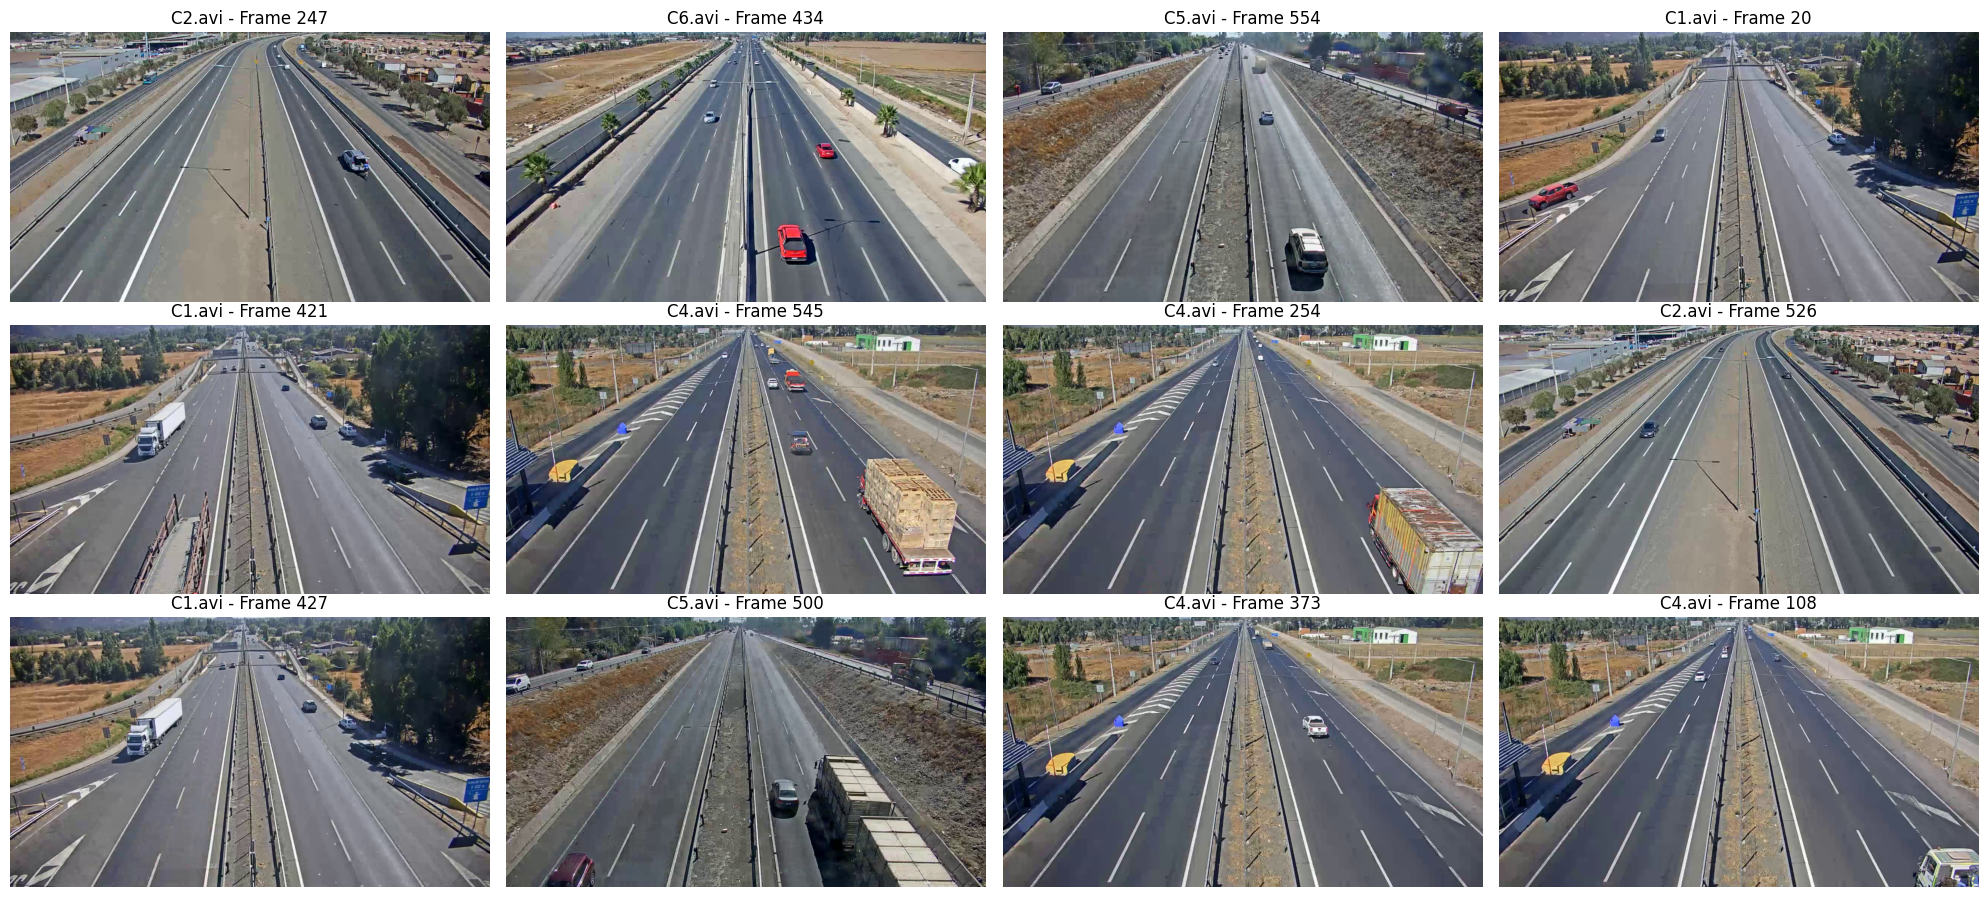

In [7]:
video_folder_path = './data/videos'
show_random_frames(video_folder_path, rows=3, cols=4)

### 1.3 Extracción de Fotogramas de Vídeos

A menudo, cuando trabajamos con análisis de vídeos, necesitamos extraer fotogramas individuales o una serie de fotogramas para diferentes propósitos, como entrenamiento de modelos, análisis frame a frame, o simplemente inspección visual. La función que hemos desarrollado a continuación facilita este proceso.

#### Función `extract_frames`:

La función `extract_frames` permite extraer fotogramas de un vídeo a un intervalo específico, determinado por el valor de `fps` (frames per second o fotogramas por segundo).

Pasos que sigue la función:

1. **Verificar el directorio de salida**: Antes de comenzar la extracción, la función verifica si el directorio donde se guardarán los fotogramas existe. Si no es el caso, lo crea.
2. **Abrir el vídeo**: Al igual que en la función anterior, utilizamos OpenCV para manejar las operaciones relacionadas con el vídeo.
3. **Iterar sobre el vídeo**: Se lee cada fotograma del vídeo. Si el número del fotograma es un múltiplo del `fps` proporcionado, se guarda en el directorio de salida.
4. **Guardar los fotogramas**: Cada fotograma se guarda con un nombre específico, que incluye el nombre del vídeo y el número del fotograma, para garantizar que cada imagen sea única y fácilmente identificable.

In [8]:
def extract_frames(video_path, output_folder, fps=1):
    # Asegurarse de que la carpeta de salida exista
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    cap = cv2.VideoCapture(video_path)
    video_fps = int(cap.get(cv2.CAP_PROP_FPS))
    video_name = os.path.basename(video_path).split('.')[0]  # Tomar el nombre del video sin la extensión

    frame_no = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_no % video_fps == 0:  # Si es un frame que queremos guardar (cada "video_fps" frames)
            output_path = os.path.join(output_folder, f"{video_name}_frame{frame_no}.jpg")
            cv2.imwrite(output_path, frame)
        frame_no += 1

    cap.release()

In [9]:
output_folder = "./data/frames_extracted"
videos_folder = "./data/videos"

# Recorrer cada video y extraer frames
for video_file in os.listdir(videos_folder):
    if video_file.endswith(".avi"):
        video_path = os.path.join(videos_folder, video_file)
        extract_frames(video_path, output_folder)

## 2. Elección del modelo
---

### ¿Por qué YOLOv8?

La tarea de detección de objetos en imágenes o vídeos es un problema fundamental en el ámbito de la visión por computadora. A medida que la investigación avanza, han surgido diferentes algoritmos y técnicas para abordar este desafío. A continuación, se detalla la justificación para la elección del modelo YOLOv8 para este proyecto.

#### Fundamentación basada en el conjunto de datos MSCOCO:
1. **MSCOCO como Benchmark**: Según una investigación, el conjunto de datos MSCOCO (Microsoft COCO: Common Objects in Context) se considera como uno de los benchmarks más desafiantes y estándares para la detección de objetos[[1]](https://arxiv.org/abs/1405.0312)[[2]](https://ieeexplore.ieee.org/document/8825470)[[3]](https://arxiv.org/abs/1809.03193).
   
   - MSCOCO contiene 91 categorías comunes de objetos con 82 de ellas teniendo más de 5,000 instancias etiquetadas[[1]](https://arxiv.org/abs/1405.0312).
   - A diferencia de otros conjuntos de datos populares como ImageNet, MSCOCO tiene menos categorías pero más instancias por categoría, lo que puede ayudar en el aprendizaje de modelos de objetos detallados capaces de una localización 2D precisa[[1]](https://arxiv.org/abs/1405.0312)[[2]](https://ieeexplore.ieee.org/document/8825470).
   - MS COCO tiene considerablemente más instancias de objetos por imagen (7.7) en comparación con ImageNet (3.0) y PASCAL (2.3)[[1]](https://arxiv.org/abs/1405.0312).

2. **YOLO y MSCOCO**: YOLO ofrece modelos pre-entrenados en MSCOCO, permitiendo así una excelente inicialización para tareas de detección de objetos específicos. Además, la naturaleza en tiempo real de YOLO lo convierte en una excelente elección para aplicaciones que requieren detecciones rápidas y precisas[[2]](https://ieeexplore.ieee.org/document/8825470).

#### Otras consideraciones:
1. **Comparación con otros modelos**: Si bien se investigaron otros modelos como Detectron2 y SSD, YOLOv8 fue preferido porque es una de las versiones más recientes y ofrece facilidad de uso, rendimiento en tiempo real y precisión.
2. **Diferentes versiones para diferentes tamaños de conjuntos de datos**: La elección específica de YOLOv8s.pt se debe a que está diseñado para conjuntos de datos más pequeños, lo que lo hace adecuado para el dataset que estamos utilizando en este proyecto.

En resumen, la elección de YOLOv8 para este proyecto se basa en la eficiencia, precisión y la disponibilidad de modelos pre-entrenados en el conjunto de datos de referencia MSCOCO.


In [10]:
# Cargar un modelo preentrenado
model = YOLO('yolov8s.pt')

100%|██████████| 21.5M/21.5M [00:01<00:00, 18.4MB/s]


## 3. Implementación y entrenamiento
---

### 3.1 Configuración inicial y Transfer Learning

<img src="https://user-images.githubusercontent.com/27466624/239739723-57391d0f-1848-4388-9f30-88c2fb79233f.jpg" width="600"/>

* **Inicialización**: La implementación comienza cargando un modelo preentrenado YOLOv8.

* **Configuración del modelo**: Se ajustan algunos parámetros del modelo, como el número de clases (nc).

* **Transfer Learning**: Se han transferido 349/355 elementos de pesos preentrenados.

### 3.2 Configuración del Conjunto de Datos

El archivo de configuración `.yaml` para YOLO describe la estructura y el contenido de nuestro conjunto de datos. Aquí está su contenido:

```yaml
# my_dataset.yaml
train: /mypath/object_detection/data/train
val: /mypath/object_detection/data/val
nc: 6  # number of classes
names: ['truck', 'car', 'bicycle', 'person', 'motorcycle', 'bus']
```

El proceso de etiquetado se realizó en **14** imágenes representativas del conjunto de datos. Para ello, se utilizó la aplicación **LabelImg**, que es una herramienta gráfica para anotar imágenes. 

Uno de los principales desafíos es la distribución desigual de las clases en el conjunto de datos. Algunas clases, como camiones y coches, pueden ser más prevalentes, mientras que otras, como bicicletas o motocicletas, pueden ser menos comunes. Esta distribución desigual puede afectar el rendimiento del modelo, haciendo que sea menos preciso en las clases menos representadas.

Además, otro desafío es la ambigüedad en las etiquetas debido a diferencias culturales o regionales. Un objeto que se considera un "carro" en una región podría ser llamado "bus" en otra.

### 3.3 Resumen y Hiperparámetros del Modelo

* **Resumen del Modelo**:  El modelo utilizado tiene 225 capas, 11,137,922 parámetros y 11,137,906 gradientes

* **Hiperparámetros**: Los hiperparámetros claves son los siguientes:

- **Epochs**: 100
- **Image Size(imgsz)**: 640
- **Optimizador**: AdamW con tasa de aprendizaje (lr) de 0.001 y momento de 0.9
- **Loss**: La pérdida se compone de box_loss, cls_loss y dfl_loss

In [11]:
results = model.train(data='./my_dataset.yaml', epochs=100, imgsz=640)

New https://pypi.org/project/ultralytics/8.0.173 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.171 🚀 Python-3.8.10 torch-2.0.1+cu117 CPU (AMD Ryzen 7 5700U with Radeon Graphics)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=./my_dataset.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=F

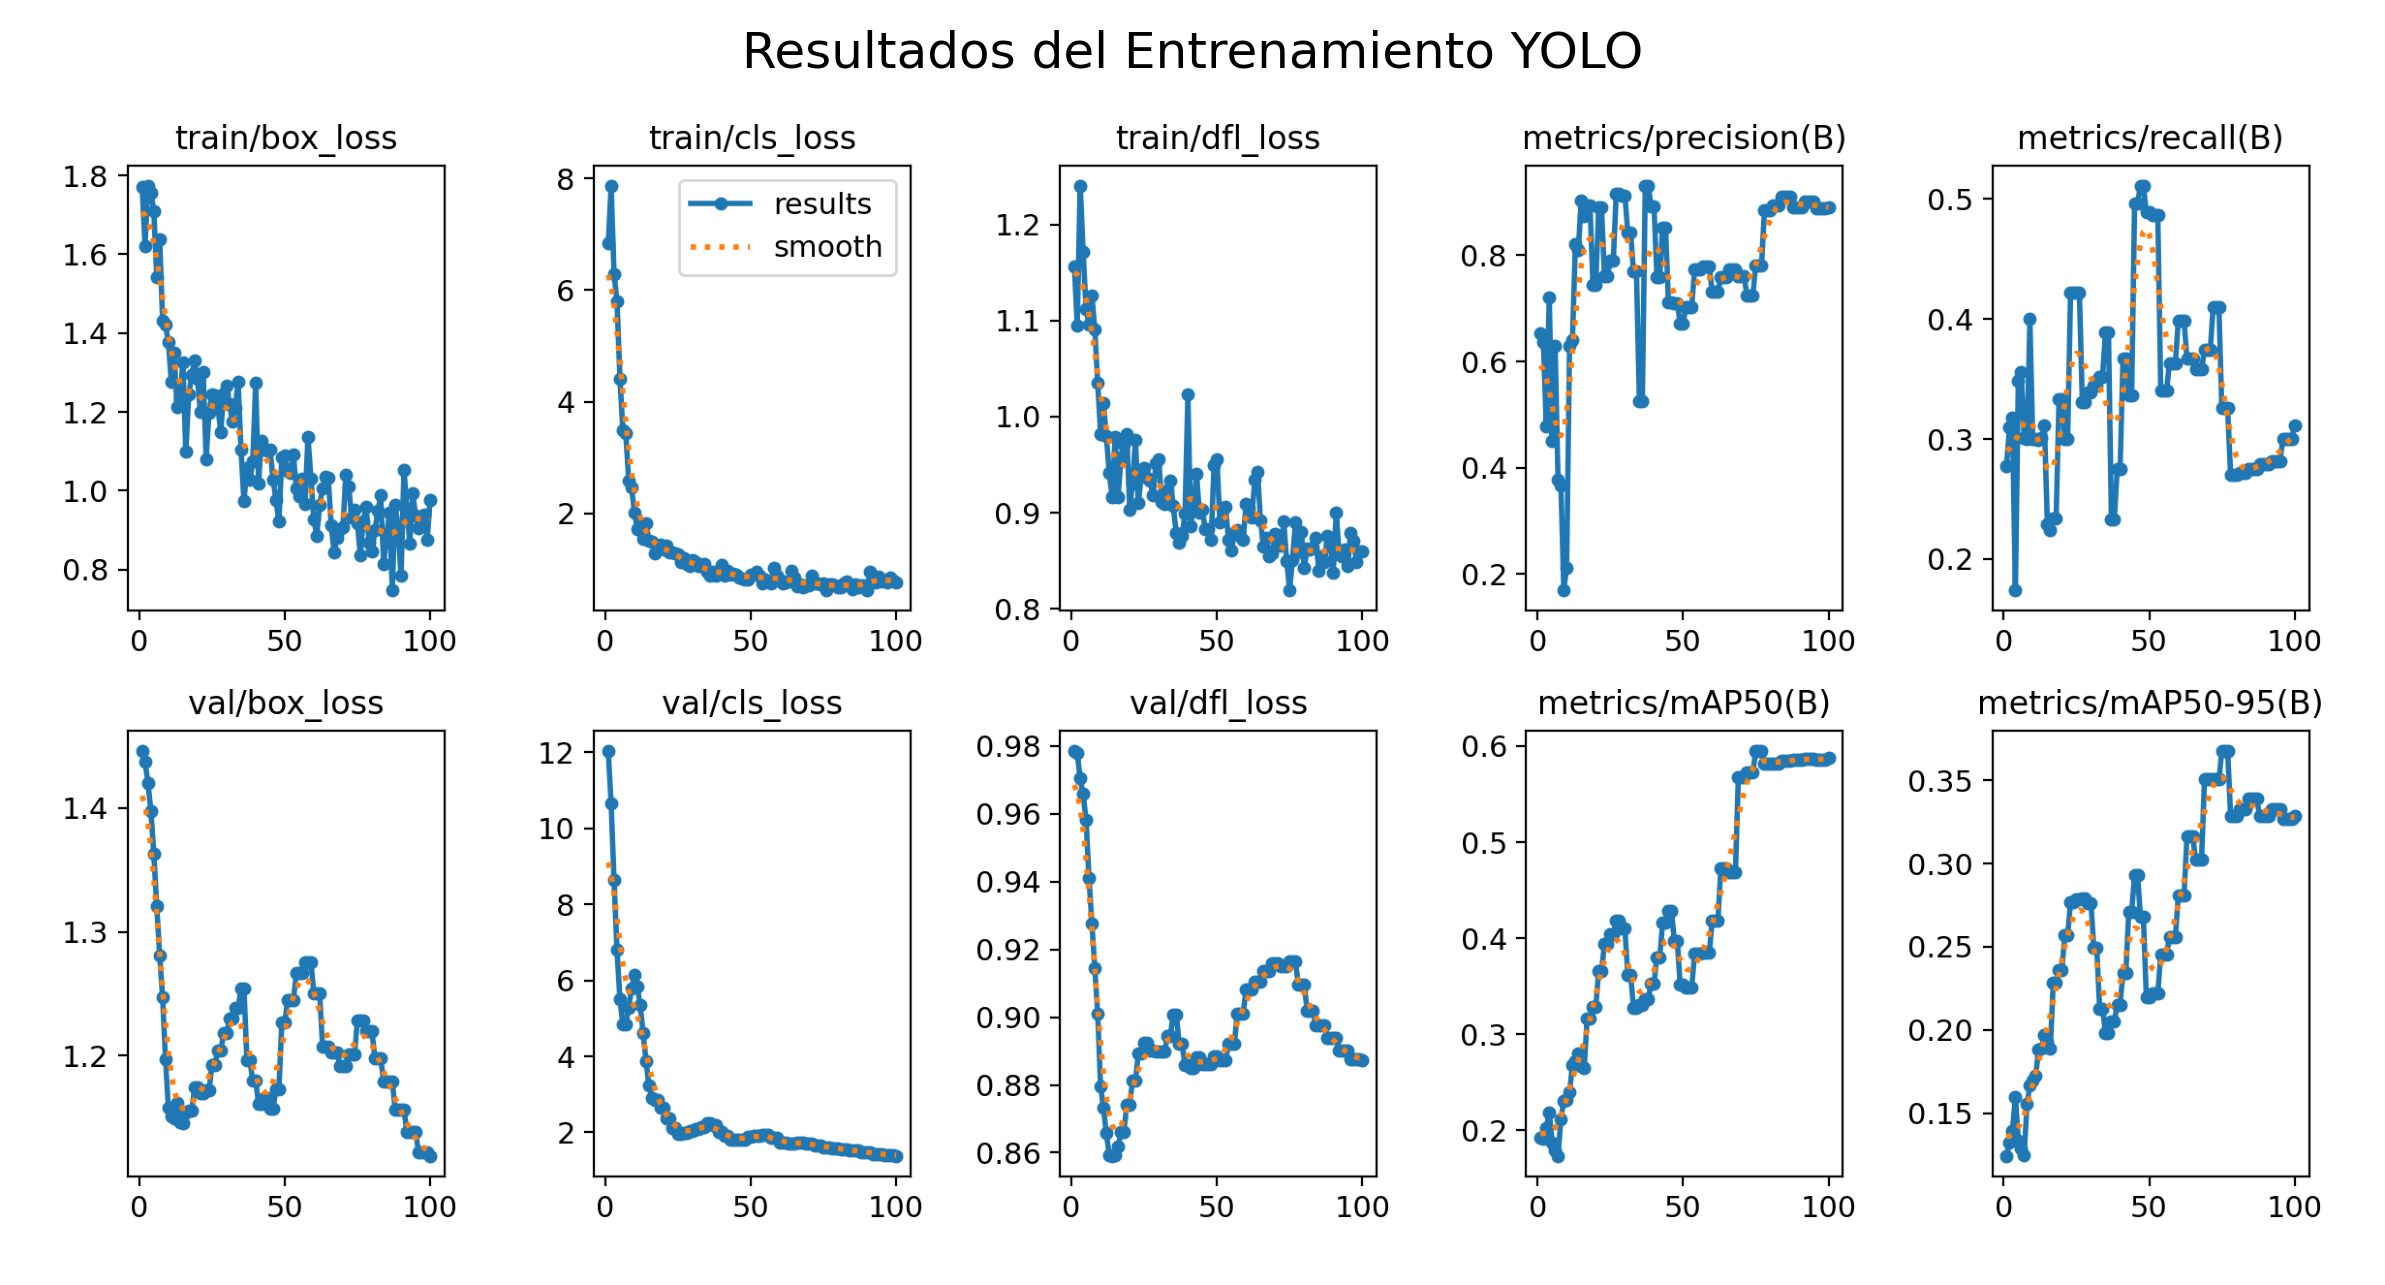

In [16]:
metrics_img = plt.imread('./runs/detect/train/results.png')

plt.figure(figsize=(10,10), dpi=300)
plt.imshow(metrics_img)
plt.title("Resultados del Entrenamiento YOLO")
plt.axis('off')
plt.show()

### 4. Visualización de Detecciones
----
Con el objetivo de evaluar la efectividad de nuestro modelo, es fundamental poder visualizar las detecciones que realiza sobre un conjunto de imágenes. La función `show_random_detections` nos permite ver las detecciones que hace nuestro modelo sobre un conjunto de imágenes aleatorias extraídas de un directorio.

Pasos de la función:
1. Obtener una lista de todas las imágenes en el directorio especificado.
2. Seleccionar un número n de imágenes al azar.
3. Mostrar las detecciones del modelo en estas imágenes en un formato gráfico.

In [14]:
def show_random_detections(model, image_folder, n=5, activate_verbose=True):
 
    # Obtener todos los archivos de imagen en el directorio
    image_files = [f for f in os.listdir(image_folder) if f.endswith(".jpg")]
    # Seleccionar n imágenes aleatoriamente
    selected_images = random.sample(image_files, n)
    # Definir el número de filas basado en el número de imágenes
    n_rows = int(np.ceil(n / 2))

    # Crear un grid de 2 columnas para mostrar las imágenes
    fig, axs = plt.subplots(n_rows, 2, figsize=(10, 3*n_rows))

    for idx, img_file in enumerate(selected_images):
        image_path = os.path.join(image_folder, img_file)

        image = cv2.imread(image_path)
        results = model([image], verbose=activate_verbose)

        for r in results:
            im_array = r.plot()

            # Obtener la ubicación actual en el grid para mostrar la imagen
            row, col = divmod(idx, 2)

            axs[row][col].imshow(cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB))
            axs[row][col].axis('off')
            axs[row][col].set_title(img_file)

    plt.tight_layout()
    plt.show()

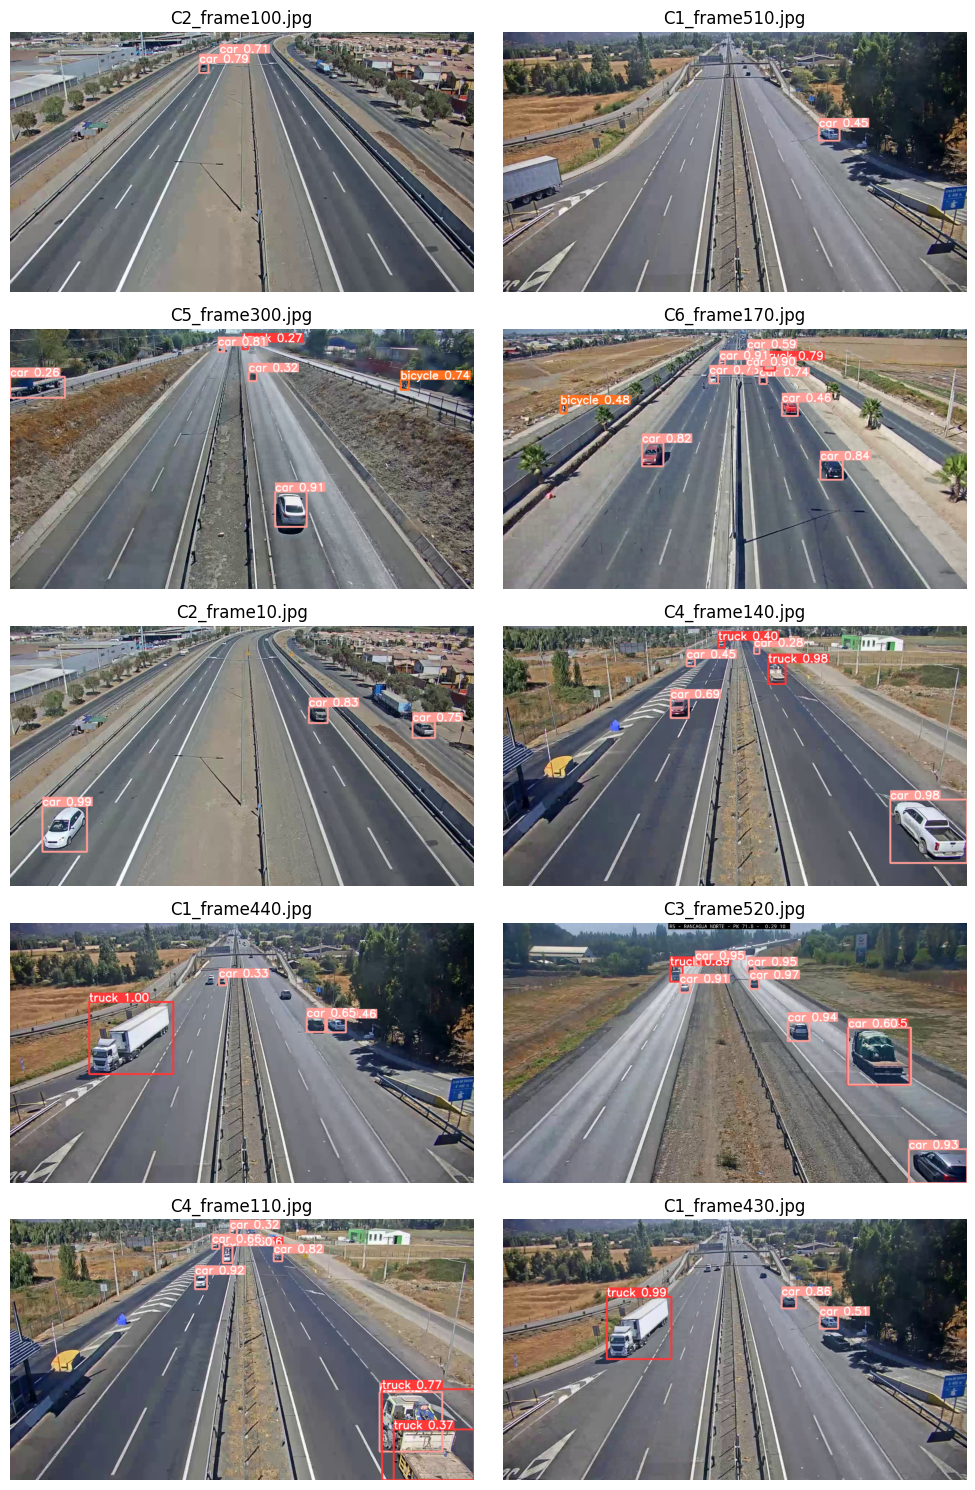

In [15]:
image_folder = './data/frames_extracted'
show_random_detections(model, image_folder, n=10, activate_verbose=False)